## COMPOSITES FOR EKMAN ON RISING AND LOWERING TEMPERATURES FOR DIFFERENT COMPONENTS

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean.cm as cmocean
from collections import OrderedDict
import cartopy.crs as ccrs
import matplotlib.path as mpath
import cftime
import glob
import dask
import os
import datetime
import matplotlib.colors as col
import gsw
from mpl_toolkits.axes_grid1 import make_axes_locatable

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
# from cosima_cookbook import distributed as ccd

In [2]:
from dask.distributed import Client

print('starting distributed client...')
client = Client()
display(client)

starting distributed client...


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43307,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.18 GiB
Comm: tcp://127.0.0.1:37513,Total threads: 4
Dashboard: /proxy/34801/status,Memory: 17.88 GiB
Nanny: tcp://127.0.0.1:46605,


In [3]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'

first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

## LOAD EKMAN. X and Y

In [4]:
#tem que repetir aqui a lat pq esta interferindo no tamanho da matriz no final d calculo
#lon_slice  = slice(-253, -248)
#lon_slice  = slice(-250.5, -248)
#lon_slice  = slice(-254, -252.5)
lon_slice  = slice(-256, -247) 
lat_slice  = slice(-75.5,-60) 


# these are the values used by MOM5
sigma = 7.292e-5     # Earth's rotation rate in radians/s
Rearth = 6371.e3 # Earth's radius in m
variable='geolat_c'
geolat_c = cc.querying.getvar(iaf_cycle3,'geolat_c',master_session, n=-1).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)

f = 2 * sigma * np.sin(np.deg2rad(geolat_c)) # convert lat in radians

In [5]:
# pick the northern latitude, so there are an equal number of t-cell and u-cell gridpoint in this range:
lon_slice  = slice(-256, -247) 
lat_slice  = slice(-75.5,-60) 


first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

tau_x_con = cc.querying.getvar(iaf_cycle3, 'tau_x', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
tau_x_con = tau_x_con.load()

tau_y_con = cc.querying.getvar(iaf_cycle3, 'tau_y', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
tau_y_con = tau_y_con.load()

In [6]:
# database for control simulation:
control = '01deg_jra55v13_ryf9091'

# Need to use these unmasked dxu and dyu, because otherwise it spreads the mask and we miss the Ekman pumping in the first ocean cell.

tau_x_con_full = cc.querying.getvar(control, 'tau_x', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
dyu = cc.querying.getvar(control, 'dyu', master_session, n=1)
dyu['ni'] = tau_x_con_full['xu_ocean'].values
dyu['nj'] = tau_x_con_full['yu_ocean'].values
#dyu = dyu.rename(({'nk':'time','ni':'xu_ocean', 'nj':'yu_ocean'}))
dyu = dyu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
dyu = dyu.sel(yu_ocean=lat_slice)

dxu = cc.querying.getvar(control, 'dxu', master_session, n=1)
dxu['ni'] = tau_x_con_full['xu_ocean'].values
dxu['nj'] = tau_x_con_full['yu_ocean'].values
#dxu = dxu.rename(({'nk':'time','ni':'xu_ocean', 'nj':'yu_ocean'}))
dxu = dxu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
dxu = dxu.sel(yu_ocean=lat_slice)

In [7]:
# See https://cosima-recipes.readthedocs.io/en/latest/documented_examples/RelativeVorticity.html#gallery-documented-examples-relativevorticity-ipynb
#ds = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc', combine='by_coords')
#inverse_dxtn = 0.5*(1/ds.dxu + np.roll(1/ds.dxu, 1, axis=1))
#inverse_dyte = 0.5*(1/ds.dyu + np.roll(1/ds.dyu, 1, axis=1))

# use dyu from above, because otherwise the nans from land spread:
inverse_dyte = 0.5*(1/dyu + np.roll(1/dyu, 1, axis=0))
inverse_dxtn = 0.5*(1/dxu + np.roll(1/dxu, 1, axis=0))

# fill land with zeros:
tauy_f_con = tau_y_con/f
tauy_f_con = tauy_f_con.fillna(0)
taux_f_con = tau_x_con/f
taux_f_con = taux_f_con.fillna(0)

In [8]:
## ALTERED FROM PREVIOUS TO CALCULATE ISOLATED COMPONENTS

# compute derivatives:
#d_dx_tauyf_con = (tauy_f_con - np.roll(tauy_f_con, 1, axis=1))*inverse_dxtn
d_dx_tauyf_con = (tauy_f_con - np.roll(tauy_f_con, 1, axis=2))*inverse_dxtn
#d_dy_tauxf_con = (taux_f_con - np.roll(taux_f_con, 1, axis=0))*inverse_dyte
d_dy_tauxf_con = (taux_f_con - np.roll(taux_f_con, 1, axis=1))*inverse_dyte

# interpolate onto the same grid:
#d_dx_tauyf_con = 0.5 * (d_dx_tauyf_con + np.roll(d_dx_tauyf_con, 1, axis=0))
d_dx_tauyf_con = 0.5 * (d_dx_tauyf_con + np.roll(d_dx_tauyf_con, 1, axis=1))
#d_dy_tauxf_con = 0.5 * (d_dy_tauxf_con + np.roll(d_dy_tauxf_con, 1, axis=1))
d_dy_tauxf_con = 0.5 * (d_dy_tauxf_con + np.roll(d_dy_tauxf_con, 1, axis=2))

# (we won't)compute curl:
#curl_tauf_con = d_dx_tauyf_con - d_dy_tauxf_con
#curl_tauf_con = curl_tauf_con.load()

#load the components for calculating the ekman 
Y = d_dy_tauxf_con.load()
X = d_dx_tauyf_con.load()

s_day=60*60*24 #convert from m/s to m/day
rho0 = 1035. #finish the calculation, could have added above with /f (Page 198 book equation 7.19a and b)
ekman_conY = -d_dy_tauxf_con/rho0*s_day
ekman_conX = d_dx_tauyf_con/rho0*s_day

# mask land:
ekman_conY = ekman_conY.where(ekman_conY!=0)
ekman_conX = ekman_conX.where(ekman_conX!=0)

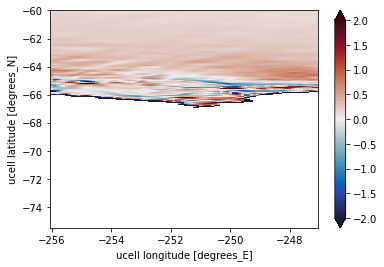

In [9]:
# quick check that this looks ok:
ekman_conY.mean('time').plot(vmin=-2,vmax=2,cmap=cmocean.balance)

### Climatology 

In [10]:
# calculate monthly climatology
climatologyX = ekman_conX.groupby('time.month').mean('time')
climatologyY = ekman_conY.groupby('time.month').mean('time')

# remove seasonal signal
ekman_con_seasonal_removed_X = (ekman_conX - climatologyX)
ekman_con_seasonal_removed_Y = (ekman_conY - climatologyY)

In [11]:
#load the variable
ekman_conX = ekman_conX.load()
ekman_con_seasonal_removed_X = ekman_con_seasonal_removed_X.load()


ekman_conY = ekman_conY.load()
ekman_con_seasonal_removed_Y = ekman_con_seasonal_removed_Y.load()
##test
#np.amin(temp_400m_za)

#### Here's a step-by-step explanation of what's happening in the code (it was developed in Figa-c_clim+roll.ipynb):

#### ekman_con has the dimensions (time=732, y=100, x=100).
#### climatology is calculated by taking the mean of ekman_con along the time dimension for each month. This results in climatology having dimensions (month=12, y=100, x=100).
#### climatology is then broadcasted to match the shape of ekman_con along the time dimension, so that it now has dimensions (time=732, month=12, y=100, x=100).
#### The broadcasted climatology is then subtracted from ekman_con, resulting in ekman_con_seasonal_removed having dimensions (time=732, month=12, y=100, x=100). This means that the month dimension is preserved in the result.

#### Because of that, we can probably remove the month dimension to not cause issues later on.

In [12]:
# select a single month and drop the 'month' dimension
ekman_con_seasonal_removed_X = ekman_con_seasonal_removed_X.isel(month=0).drop('month')
ekman_con_seasonal_removed_Y = ekman_con_seasonal_removed_Y.isel(month=0).drop('month')

### Apparently they are, so my procedure should have worked. I will try detrending and rolling a 12 month mean through the new data

### First run the function to detrend the time series later on 

### Function for doing spatial correlations/regressions:

#### This comes from http://hrishichandanpurkar.blogspot.com/2017/09/vectorized-functions-for-correlation.html


In [13]:
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

# detrending function:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [14]:
# Note we need to first detrend the data:
ekman_con_seasonal_removed_X_roll = ekman_con_seasonal_removed_X.rolling(time=12, center=True).mean()
ekman_con_seasonal_removed_Y_roll = ekman_con_seasonal_removed_Y.rolling(time=12, center=True).mean()


### loading indexes previously calculated by "Selecting_peak_low_years" code stored in /Figures/New_codes_CFD

In [15]:
outpath = '/g/data/v45/ns3783/top_index.nc'
profile_data = xr.open_dataset(outpath)
top_id = profile_data.top_id

In [16]:
outpath = '/g/data/v45/ns3783/bottom_index.nc'
profile_data = xr.open_dataset(outpath)
bt_id = profile_data.bt_id



### loading indexes previously calculated by "Selecting_peak_low_years" code stored in /Figures/New_codes_CFD

In [17]:
outpath = '/g/data/v45/ns3783/top_index.nc'
profile_data = xr.open_dataset(outpath)
top_id = profile_data.top_id

In [18]:
outpath = '/g/data/v45/ns3783/bottom_index.nc'
profile_data = xr.open_dataset(outpath)
bt_id = profile_data.bt_id

In [19]:
## because bt_id has high indexes we need to get rid off them. This data is no longer existent if we shift ekman back 8, 9,10 months / ekman_roll now has time 727
bt_6=bt_id[:-2]


### creating the averages for peaks and lows for normal just roll

In [20]:
#full mean X
ekman_con_avgX_c = ekman_con_seasonal_removed_X_roll.mean('time')
ekman_con_avgX_c = ekman_con_avgX_c.load()

#mean of all high peaks together X
ekman_high_avgX_c = ekman_con_seasonal_removed_X_roll[top_id].mean('time')
ekman_high_avgX_c = ekman_high_avgX_c.load()

#mean of all low peaks together X
ekman_low_avgX_c = ekman_con_seasonal_removed_X_roll[bt_6].mean('time')
ekman_low_avgX_c = ekman_low_avgX_c.load()

#full mean Y
ekman_con_avgY_c = ekman_con_seasonal_removed_Y_roll.mean('time')
ekman_con_avgY_c = ekman_con_avgY_c.load()

#mean of all high peaks together X
ekman_high_avgY_c = ekman_con_seasonal_removed_Y_roll[top_id].mean('time')
ekman_high_avgY_c = ekman_high_avgY_c.load()

#mean of all low peaks together X
ekman_low_avgY_c = ekman_con_seasonal_removed_Y_roll[bt_6].mean('time')
ekman_low_avgY_c = ekman_low_avgY_c.load()


### creating the averages for peaks and lows with climatology

In [21]:
#full mean X
ekman_con_avgX = ekman_conX.mean('time')
ekman_con_avgX = ekman_con_avgX.load()

#mean of all high peaks together X
ekman_high_avgX = ekman_conX[top_id].mean('time')
ekman_high_avgX = ekman_high_avgX.load()

#mean of all low peaks together X
ekman_low_avgX = ekman_conX[bt_6].mean('time')
ekman_low_avgX = ekman_low_avgX.load()

#full mean Y
ekman_con_avgY = ekman_conY.mean('time')
ekman_con_avgY = ekman_con_avgY.load()

#mean of all high peaks together Y
ekman_high_avgY = ekman_conY[top_id].mean('time')
ekman_high_avgY = ekman_high_avgY.load()

#mean of all low peaks together Y
ekman_low_avgY = ekman_conY[bt_6].mean('time')
ekman_low_avgY = ekman_low_avgY.load()

## PLOT COMPOSITES FOR EKMAN

In [22]:
# import bathymetry and the land/ocean mask to add to plot:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# create land mask from the bathymetry:
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)]=1
land_mask = np.where(land_mask==1,land_mask,np.nan)

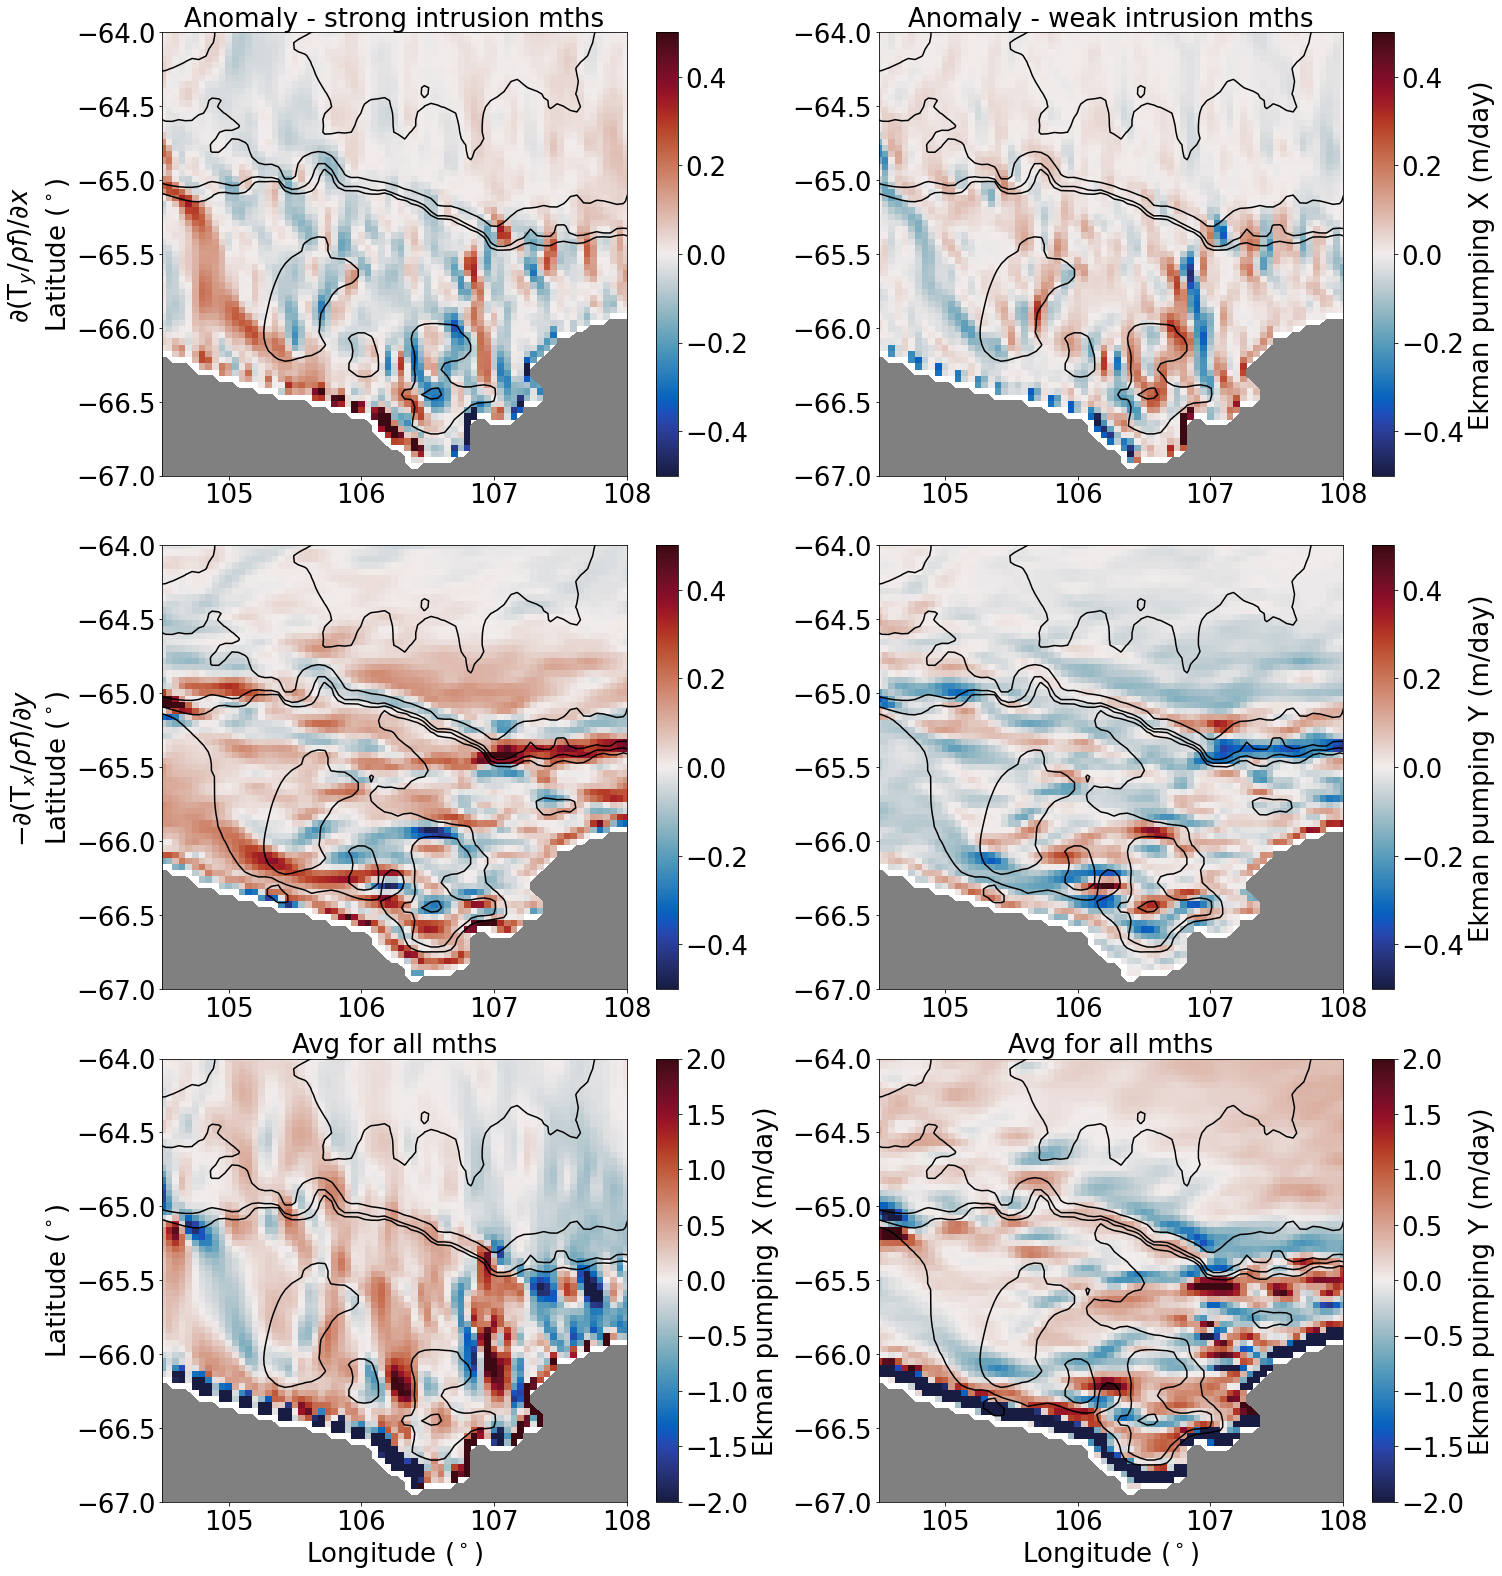

In [23]:
### test new values
fontsize=26

#for nt in range(0,nframes):
fig=plt.figure(figsize=(21, 22))
fig.subplots_adjust(top=0.88)

t_high = ekman_high_avgX_c-ekman_con_avgX_c;
t_low = ekman_low_avgX_c-ekman_con_avgX_c;
ax0=plt.subplot(321) 
pc = plt.pcolormesh(t_high.xu_ocean,t_high.yu_ocean,
                        t_high, cmap = cmocean.balance, 
                        vmin=-.5,vmax=.5)
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
#plt.title('Anomaly for rising Temp yrs',fontsize=fontsize)
plt.title('Anomaly - strong intrusion mths',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[700,1000,2000,3000],colors='k',linewidth=.5)
#plt.plot([-252.1,-250.1],[-64.8,-65.1],color='C0',linestyle='--',linewidth=2)
# plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.ylabel('Temp 400m',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -248))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'($\circ$C)', fontsize = 16,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
ax0.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])
plt.ylabel('$\partial(\u03A4_{y}/\u03C1 f)/\partial x$\nLatitude ($^\circ$)',fontsize=fontsize)
#plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(3,2,2)      
pc = plt.pcolormesh(t_low.xu_ocean,t_low.yu_ocean,
                       t_low, cmap = cmocean.balance, 
                        vmin=-.5,vmax=.5)
#plt.title('Anomaly for Weak Heat Flux (Y) yrs',fontsize=fontsize)
#plt.title('Anomaly for lowering Temp yrs',fontsize=fontsize)
plt.title('Anomaly - weak intrusion mths',fontsize=fontsize)
#plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[700,1000,2000,3000],colors='k',linewidth=.5)
#plt.plot([-252.1,-250.1],[-64.8,-65.1],color='C0',linestyle='--',linewidth=2)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -248))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'($\circ$C)', fontsize = 16,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(r'Ekman pumping X (m/day)', fontsize = fontsize,labelpad=5)
ax0.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
#plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(3,2,5)    
pc = plt.pcolormesh(ekman_con_avgX_c.xu_ocean,ekman_con_avgX_c.yu_ocean,
                        ekman_con_avgX_c, cmap = cmocean.balance, 
                        vmin=-2,vmax=2)
plt.title('Avg for all mths',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[700,1000,2000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -248))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Ekman pumping X (m/day)', fontsize = fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
ax0.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

##########
t_high = ekman_high_avgY_c-ekman_con_avgY_c;
t_low = ekman_low_avgY_c-ekman_con_avgY_c;
ax0=plt.subplot(323) 
pc = plt.pcolormesh(t_high.xu_ocean,t_high.yu_ocean,
                        t_high, cmap = cmocean.balance, 
                        vmin=-.5,vmax=.5)
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
#plt.title('Anomaly for rising Temp yrs',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
#plt.plot([-252.1,-250.1],[-64.8,-65.1],color='C0',linestyle='--',linewidth=2)
# plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.ylabel('Temp 400m',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -248))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'($\circ$C)', fontsize = 16,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
ax0.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])
plt.ylabel('$-\partial(\u03A4_{x}/\u03C1 f)/\partial y$\nLatitude ($^\circ$)',fontsize=fontsize)
#plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(3,2,4)      
pc = plt.pcolormesh(t_low.xu_ocean,t_low.yu_ocean,
                       t_low, cmap = cmocean.balance, 
                        vmin=-.5,vmax=.5)
#plt.title('Anomaly for Weak Heat Flux (Y) yrs',fontsize=fontsize)
#plt.title('Anomaly for lowering Temp yrs',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
#plt.plot([-252.1,-250.1],[-64.8,-65.1],color='C0',linestyle='--',linewidth=2)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -248))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'($\circ$C)', fontsize = 16,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(r'Ekman pumping Y (m/day)', fontsize = fontsize,labelpad=5)
ax0.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
#plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(3,2,6)    
pc = plt.pcolormesh(ekman_con_avgY_c.xu_ocean,ekman_con_avgY_c.yu_ocean,
                        ekman_con_avgY_c, cmap = cmocean.balance, 
                        vmin=-2,vmax=2)
#plt.title('Avg for all yrs',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -248))
plt.title('Avg for all mths',fontsize=fontsize)
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Ekman pumping Y (m/day)', fontsize = fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
ax0.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)



fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
filestr = figdir+'/fig_ekman_compositeXY_peak_low.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

Text(0.5, 0, 'Longitude ($^\\circ$)')

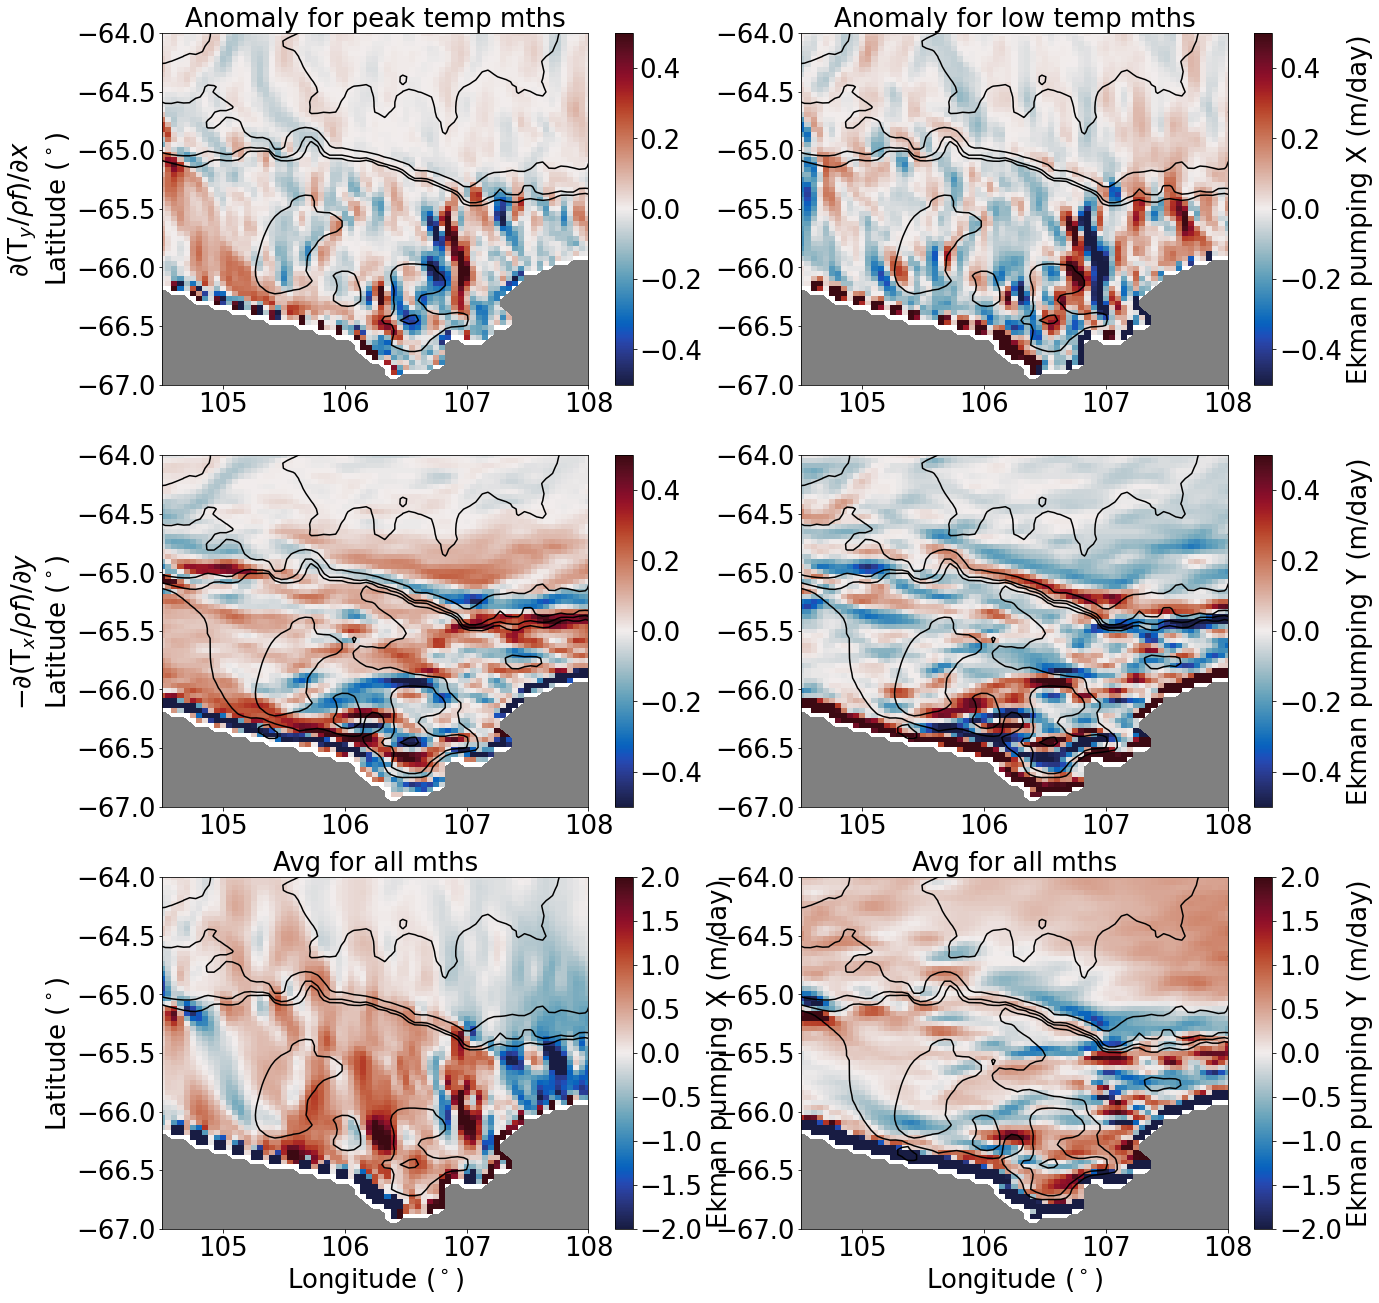

In [38]:
### test new values
fontsize=26

#for nt in range(0,nframes):
fig=plt.figure(figsize=(21, 22))
fig.subplots_adjust(top=0.88)

t_high = ekman_high_avgX-ekman_con_avgX;
t_low = ekman_low_avgX-ekman_con_avgX;
ax0=plt.subplot(321) 
pc = plt.pcolormesh(t_high.xu_ocean,t_high.yu_ocean,
                        t_high, cmap = cmocean.balance, 
                        vmin=-.5,vmax=.5)
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
#plt.title('Anomaly for rising Temp yrs',fontsize=fontsize)
plt.title('Anomaly for peak temp mths',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[700,1000,2000,3000],colors='k',linewidth=.5)
#plt.plot([-252.1,-250.1],[-64.8,-65.1],color='C0',linestyle='--',linewidth=2)
# plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.ylabel('Temp 400m',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -248))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'($\circ$C)', fontsize = 16,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
ax0.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])
plt.ylabel('$\partial(\u03A4_{y}/\u03C1 f)/\partial x$\nLatitude ($^\circ$)',fontsize=fontsize)
#plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(3,2,2)      
pc = plt.pcolormesh(t_low.xu_ocean,t_low.yu_ocean,
                       t_low, cmap = cmocean.balance, 
                        vmin=-.5,vmax=.5)
#plt.title('Anomaly for Weak Heat Flux (Y) yrs',fontsize=fontsize)
#plt.title('Anomaly for lowering Temp yrs',fontsize=fontsize)
plt.title('Anomaly for low temp mths',fontsize=fontsize)
#plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[700,1000,2000,3000],colors='k',linewidth=.5)
#plt.plot([-252.1,-250.1],[-64.8,-65.1],color='C0',linestyle='--',linewidth=2)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -248))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'($\circ$C)', fontsize = 16,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(r'Ekman pumping X (m/day)', fontsize = fontsize,labelpad=5)
ax0.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
#plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(3,2,5)    
pc = plt.pcolormesh(ekman_con_avgX.xu_ocean,ekman_con_avgX.yu_ocean,
                        ekman_con_avgX, cmap = cmocean.balance, 
                        vmin=-2,vmax=2)
plt.title('Avg for all mths',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[700,1000,2000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -248))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Ekman pumping X (m/day)', fontsize = fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
ax0.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

##########
t_high = ekman_high_avgY-ekman_con_avgY;
t_low = ekman_low_avgY-ekman_con_avgY;
ax0=plt.subplot(323) 
pc = plt.pcolormesh(t_high.xu_ocean,t_high.yu_ocean,
                        t_high, cmap = cmocean.balance, 
                        vmin=-.5,vmax=.5)
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
#plt.title('Anomaly for rising Temp yrs',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
#plt.plot([-252.1,-250.1],[-64.8,-65.1],color='C0',linestyle='--',linewidth=2)
# plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.ylabel('Temp 400m',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -248))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'($\circ$C)', fontsize = 16,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
ax0.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])
plt.ylabel('$-\partial(\u03A4_{x}/\u03C1 f)/\partial y$\nLatitude ($^\circ$)',fontsize=fontsize)
#plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(3,2,4)      
pc = plt.pcolormesh(t_low.xu_ocean,t_low.yu_ocean,
                       t_low, cmap = cmocean.balance, 
                        vmin=-.5,vmax=.5)
#plt.title('Anomaly for Weak Heat Flux (Y) yrs',fontsize=fontsize)
#plt.title('Anomaly for lowering Temp yrs',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
#plt.plot([-252.1,-250.1],[-64.8,-65.1],color='C0',linestyle='--',linewidth=2)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -248))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'($\circ$C)', fontsize = 16,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(r'Ekman pumping Y (m/day)', fontsize = fontsize,labelpad=5)
ax0.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
#plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(3,2,6)    
pc = plt.pcolormesh(ekman_con_avgY.xu_ocean,ekman_con_avgY.yu_ocean,
                        ekman_con_avgY, cmap = cmocean.balance, 
                        vmin=-2,vmax=2)
#plt.title('Avg for all yrs',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -248))
plt.title('Avg for all mths',fontsize=fontsize)
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Ekman pumping Y (m/day)', fontsize = fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
ax0.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)



#ig.tight_layout()
#figdir = '/home/581/ns3783/Scripts/Figures/New_codes_CFD/Figures'
#filestr = figdir+'/fig_ekman_compositeXY_peak_low.png'
#plt.savefig(filestr,dpi=600,bbox_inches='tight')